In [7]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

import random
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

from user_fun.get_net import ForwardNetwork
from user_fun.solver.cp_solver import CloudPointSolver
from user_fun.baseline import sint
from user_fun.bc import data_loss_factory

debug_print_flag = True
# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

cloud_point_list,loss_list = sint.get_long_time_problem()

t_span_list = np.array([[0,2.2],[2,4.2],[4,6]])
model_num = len(t_span_list)
send_t_span = [None for i in range(len(t_span_list))]
for i in range(model_num):
    if i == len(t_span_list)-1:
        send_t_span[i] = []
    else:
        send_t_span[i] = [t_span_list[i+1][0],t_span_list[i][1]]

send_t_span_xpinn = [None for i in range(len(t_span_list))]
for i in range(model_num):
    if i == 0:
        send_t_span_xpinn[i] = []
    else:
        send_t_span_xpinn[i] = [t_span_list[i][0],t_span_list[i-1][1]]

if debug_print_flag:
    print('send_t_span', send_t_span)


""" 对数据集进行切分，默认x_data最后一维是时间维，x_data中涉及到的在交界区域内的任意类
    型的采样点均会被视为交界损失的发生点。
"""
def get_span_cp_loss(cloud_point_list,loss_list,t_span):
    """
    len(cloud_point_list) : 损失项的数量
    """
    res_cloud_point_list = []
    res_loss_list = []
    if not(t_span is None):
        for cp_item,loss_item in zip(cloud_point_list,loss_list):
            x_data,y_data = cp_item
            idx = (x_data[:,-1]>=t_span[0]) & (x_data[:,-1]<=t_span[1])
            choose_x_data = x_data[idx,:]
            choose_y_data = y_data[idx,:]
            if len(choose_x_data)!=0:
                res_cloud_point_list.append([choose_x_data, choose_y_data])
                res_loss_list.append(loss_item)
        return res_cloud_point_list,res_loss_list

# 初值赋予
cp_para_list = []
loss_para_list = []
solver_list = []
for model_id in range(model_num):
    cp_para_item, loss_para_item = \
        get_span_cp_loss(cloud_point_list, loss_list, t_span_list[model_id])
    cp_para_list.append(cp_para_item)
    loss_para_list.append(loss_para_item)
    solver_list.append(CloudPointSolver(
        model = [1, 100, 100, 100, 1],
        optimizer = "adam"))

epoch_num = 600
info_exchange_round = 10
test_round = 20

# 初始化通信组件
send_xdata_list = [None for i in range(model_num)]
send_cp_list = [None for i in range(model_num)]
recv_cp_list = [None for i in range(model_num)]
for model_id in range(model_num):
    if model_id != model_num - 1:
        cp_para_item, _ = \
            get_span_cp_loss(cloud_point_list, loss_list, send_t_span[model_id])
        x_data_item_list = [item[0] for item in cp_para_item]
        send_xdata_list[model_id] = np.vstack(x_data_item_list)

send_xdata_list_xpinn = [None for i in range(model_num)]
send_cp_list_xpinn = [None for i in range(model_num)]
recv_cp_list_xpinn = [None for i in range(model_num)]
for model_id in range(model_num):
    if model_id != 0:
        cp_para_item, _ = \
            get_span_cp_loss(cloud_point_list, loss_list, send_t_span_xpinn[model_id])
        x_data_item_list = [item[0] for item in cp_para_item]
        send_xdata_list_xpinn[model_id] = np.vstack(x_data_item_list)

data_loss = data_loss_factory(loss_fn)

def get_error():
    x_all = []
    y_all = []
    for model_id in range(model_num):
        ## define a pde
        t_span_start = 2*model_id
        t_span_end = 2*model_id+2 +0.2

        x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
        y_cpu = solver_list[model_id].model_eval(x_cpu, use_best_model_flag = True)

        if model_id == 0:
            x_all = x_cpu
            y_all = y_cpu
        else:
            x_all = np.vstack([x_all,x_cpu])
            y_all = np.vstack([y_all,y_cpu])
    y_all_real = np.cos(np.pi*np.array(x_all))
    total_error = np.mean(np.abs(np.array(y_all_real)-np.array(y_all)))
    print('total error',total_error)
    return x_all,y_all,total_error

error_list = []
x_all_list = []
y_all_list = []

for epoch in range(epoch_num):
    if epoch % info_exchange_round == 0:
        # 采样
        for model_id in range(model_num):
            if model_id!=model_num-1:
                y_data = \
                    solver_list[model_id].model_eval(send_xdata_list[model_id])
                send_cp_list[model_id] = (send_xdata_list[model_id], y_data)
            if model_id!=0:
                y_data_xpinn = \
                    solver_list[model_id].model_eval(send_xdata_list_xpinn[model_id])
                send_cp_list_xpinn[model_id] = (send_xdata_list_xpinn[model_id], y_data_xpinn)
        # 通信
        for model_id in range(model_num):     
            if model_id != 0:
                recv_cp_list[model_id] = send_cp_list[model_id-1]
            # xpinn
            if model_id != model_num-1:
                recv_cp_list_xpinn[model_id] = send_cp_list_xpinn[model_id + 1]

    if epoch % test_round == 0:
        for model_id in range(model_num):
            if model_id == 0:
                used_cp_para_item = cp_para_list[model_id]
                used_loss_para_item = loss_para_list[model_id]
            else:
                used_cp_para_item = \
                    cp_para_list[model_id] + [recv_cp_list[model_id]]
                used_loss_para_item = loss_para_list[model_id] + [data_loss]

            if model_id != model_num - 1:
                used_cp_para_item.append(recv_cp_list_xpinn[model_id])
                used_loss_para_item.append(data_loss)

            solver_list[model_id].test_step(
                cloud_point_list = used_cp_para_item,
                loss_list = used_loss_para_item,
                print_flag = True
            )
        x_all_item,y_all_item,error_item = get_error()
        x_all_list.append(x_all_item)
        y_all_list.append(y_all_item)
        error_list.append(error_item)

    for model_id in range(model_num):
        if model_id == 0:
            used_cp_para_item = cp_para_list[model_id]
            used_loss_para_item = loss_para_list[model_id]
        else:
            used_cp_para_item = \
                cp_para_list[model_id] + [recv_cp_list[model_id]]
            used_loss_para_item = loss_para_list[model_id] + [data_loss]

        solver_list[model_id].train_step(
            cloud_point_list = used_cp_para_item,
            loss_list = used_loss_para_item
        )



send_t_span [[2.0, 2.2], [4.0, 4.2], []]
loss is [4.528852   1.2207861  0.04255627 5.7921944 ]
loss is [4.552874   0.04255627 0.02987591 4.625306  ]
loss is [4.889859   0.02987591 4.919735  ]
total error 0.6451751521206593
loss is [3.3133428e+00 7.2229295e-03 1.1276179e-03 1.1276179e-03 3.3228211e+00]
loss is [3.9482641  0.00758212 2.3287113  6.2845573 ]
loss is [4.7707205e+00 8.0862344e-05 4.7708015e+00]
total error 0.6073265779731091
loss is [1.3362948  0.00293269 0.01108667 0.01108667 0.01108667 1.3724875 ]
loss is [3.1266785 0.0411617 0.5731278 3.740968 ]
loss is [4.4275808e+00 2.1883175e-03 4.4297690e+00]
total error 0.6310181660581186
loss is [0.8090111  0.030604   0.00499183 0.00499183 0.00499183 0.0855476
 0.9401382 ]
loss is [2.5668757  0.05386056 0.03901872 2.659755  ]
loss is [3.6939082 0.234731  3.9286392]
total error 0.6009547378643499
loss is [0.64201486 0.02404362 0.0031077  0.0031077  0.0031077  0.07342282
 0.03992083 0.78872526]
loss is [2.2213902  0.03402703 0.1512880

total error 0.7182264317199588


C:\Users\hpc\AppData\Local\Temp\ipykernel_9836\703156860.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_log[0] = np.array(solver_list[0].get_logger())


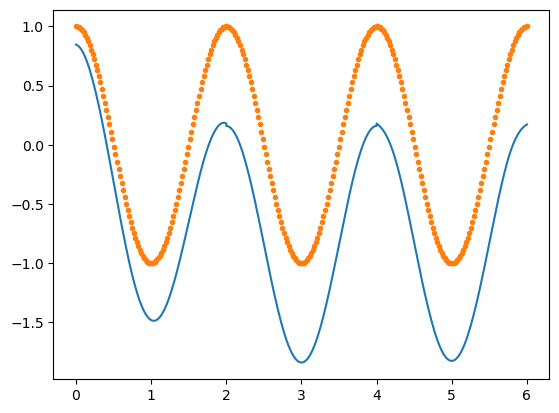

<Figure size 640x480 with 0 Axes>

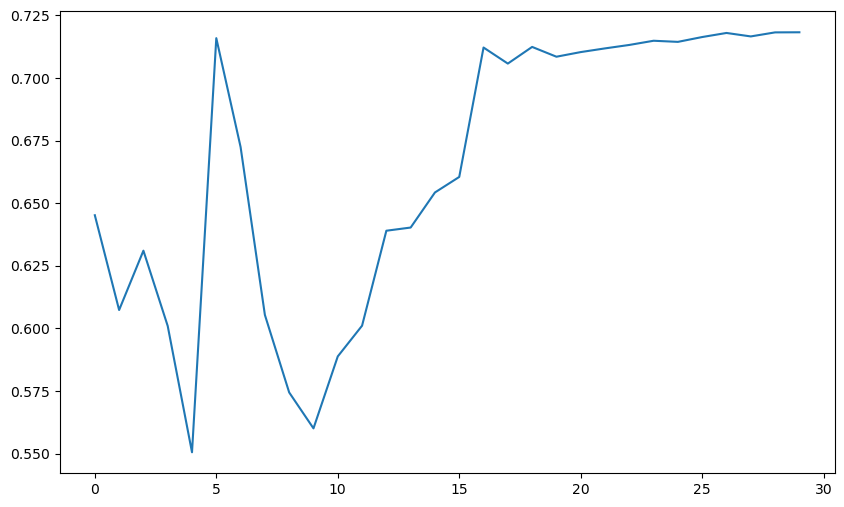

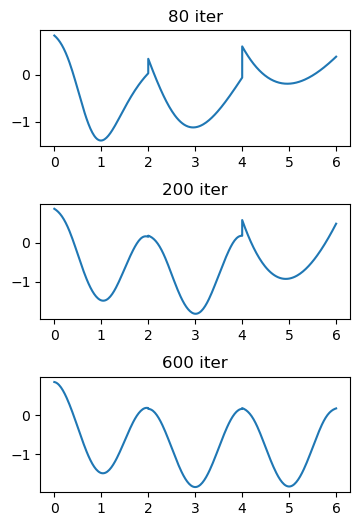

In [11]:

# EVAL:BEGIN
x_all = []
y_all = []


for model_id in range(model_num):
    ## define a pde
    t_span_start = 2*model_id
    t_span_end = 2*model_id+2 +0.2

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver_list[model_id].model_eval(x_cpu, use_best_model_flag = True)

    if model_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])
# EVAL:END

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
y_all_real = np.cos(np.pi*np.array(x_all))
ax.plot(np.array(x_all), y_all_real,'.')
y_all_real = np.cos(np.pi*np.array(x_all))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_all))) )

plt.figure()
test_log = [None for i in range(3)]
test_log[0] = np.array(solver_list[0].get_logger())
test_log[1] = np.array(solver_list[1].get_logger())
test_log[2] = np.array(solver_list[2].get_logger())

# fig,ax = plt.subplots(figsize=(10,6))
# print(test_log[0].shape)
# print(test_log[1].shape)
# print(test_log[2].shape)
# x_iter_plot = range(0,epoch,test_round)
# ax.plot(x_iter_plot,test_log[0][:,0],'b',label = 'model1:pde loss')
# ax.plot(x_iter_plot,test_log[0][:,1],'b--',label = 'model1:init loss')
# ax.plot(x_iter_plot,test_log[1][:,0],'m',label = 'model2:pde loss')
# ax.plot(x_iter_plot,test_log[1][:,1],'m--',label = 'model2:interface loss')
# ax.plot(x_iter_plot,test_log[2][:,0],'r',label = 'model3:pde loss')
# ax.plot(x_iter_plot,test_log[2][:,1],'r--',label = 'model3:interface loss')
# ax.legend()
# ax.set_xlabel('epoch')
# ax.set_ylabel('loss')
# ax.set_yscale('log')

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(error_list)

fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(4,6))
ax0.plot(x_all_list[4],y_all_list[4])
ax0.set_title('80 iter')
ax1.plot(x_all_list[10],y_all_list[10])
ax1.set_title('200 iter')
ax2.plot(x_all_list[29],y_all_list[29])
ax2.set_title('600 iter')
fig.subplots_adjust(hspace=0.5)

In [10]:
print(error_list)

[0.6451751521206593, 0.6073265779731091, 0.6310181660581186, 0.6009547378643499, 0.5505193403783322, 0.7158746381600698, 0.6724128262388209, 0.6053660251758992, 0.5744138184810629, 0.5600673265690345, 0.5887987089047202, 0.6010643163635122, 0.6389868032870193, 0.6402568127587438, 0.6542623607628048, 0.6604635083675384, 0.7121358568966388, 0.7057262744133671, 0.7123808969681462, 0.7084693989778559, 0.7103183370704452, 0.7117925225694974, 0.7131686373800039, 0.71484337353458, 0.7143959731484453, 0.7163280815755327, 0.7179530813358724, 0.7165708807421227, 0.7181836688145995, 0.7182264317199588]
